## Load and filter classes
The first thing we need to do is to select the sounds we're going to identify from the labels indexes csv file

In [1]:
import pandas as pd

classes_file = "../dataset/class_labels_indices.csv"
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]
df = pd.read_csv(classes_file)
df.set_index("index", inplace=True)
selected_classes_indexes = df.index[df['display_name'].isin(selected_classes)].tolist()
selected_classes_dict = dict(zip(selected_classes_indexes, selected_classes))
print(selected_classes_dict)

{53: 'Vehicle horn, car horn, honking', 68: 'Children playing', 71: 'Dog', 74: 'Jackhammer', 111: 'Siren', 308: 'Traffic noise, roadway noise', 327: 'Subway, metro, underground', 334: 'Walk, footsteps', 396: 'Chatter', 420: 'Bird'}


### Create an encoder for our labels

In [2]:
import pickle
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([selected_classes_indexes])
print(list(mlb.classes_))

# Save mlb for our project
dump_filename = "multiLabelBinarizer.pkl"
with open(dump_filename, "wb") as dump_file:
    pickle.dump(mlb, dump_file)

[53, 68, 71, 74, 111, 308, 327, 334, 396, 420]


## Extract features from dataset
Now, we need to build a function to extract features from Google Audioset, which are formatted in tensorflow

In [3]:
import os
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

def extract_features(dataset_dir, mlb):
    X = []
    y = []
    recordset = os.listdir(dataset_dir)
    for record in recordset:
        raw_dataset = tf.data.TFRecordDataset(dataset_dir+record)    
        for raw_record in raw_dataset.take(1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            labels = example.features.feature['labels'].int64_list.value
            # print(labels)

            for label in labels:
                if label in selected_classes_indexes:
                    # video = example.features.feature['video_id'].bytes_list.value[0].decode("utf-8")
                    # start = example.features.feature['start_time_seconds'].float_list.value[0]
                    # end = example.features.feature['end_time_seconds'].float_list.value[0]
                    # print(f"Video: {video}")
                    # print(f"Duration: {end-start} seconds")
                    
                    labels_detected = set(labels).intersection(set(selected_classes_indexes))
                    # print(f"Labels: ", labels_detected)
                    
                    example_seq = tf.train.SequenceExample()
                    example_seq.ParseFromString(raw_record.numpy())
                    
                    try:
                        i=0
                        feats_list = example_seq.feature_lists.feature_list['audio_embedding']
                        while True:
                            hex_features = feats_list.feature[i].bytes_list.value[0].hex()
                            features_array = [int(hex_features[k:k+2],16) for k in range(0,len(hex_features),2)]
                            # for l in labels_detected:
                                # If there's more than one of the selected labels in the video
                            X.append(features_array)
                            y.append(list(labels_detected))
                            i += 1
                    except IndexError as ie:
                            #FeatureList does not have length, so we read until the end
                            continue
                            
    X = np.array(X)
    y = np.array(y, dtype=object)
    
    # Apply OneHotEncodig to ground truth
    y = mlb.transform(y)

    # We need to add at least one dimension to our X   
    X = X.reshape(X.shape[0], 128, 1)
    return X,y

In [4]:
# Extract data for training
X_train, y_train = extract_features("../dataset/audioset_v1_embeddings/bal_train/", mlb)

print(X_train.shape, y_train.shape)

(1978, 128, 1) (1978, 10)


In [6]:
# Extract also X and y for validation
X_val, y_val = extract_features("../dataset/audioset_v1_embeddings/eval/", mlb)
print(X_val.shape, y_val.shape)

(2233, 128, 1) (2233, 10)


# Define neural network for classification
We need a neural network with 128 inputs and 10 outputs (one for each audio class). As each audio could be multilabelled, it is not recommended to use softmax as output layer but sigmoid (https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

model = Sequential([
    #Conv1D(32, 3, padding="same", input_shape=X_train[0].shape, activation="relu", name="input"),
    Conv1D(128, 3, padding="same", input_shape=X_train[0].shape, activation="relu", name="input"),
    MaxPool1D(pool_size=2, name="maxpool1"),
    
    #Conv1D(64, 3, padding="same", activation="relu", name="conv1D_1"),
    Conv1D(128, 3, padding="same", activation="relu", name="conv1D_1"),
    MaxPool1D(pool_size=2, name="maxpool2"),
    
    #Conv1D(128, 3, padding="same", activation="relu", name="conv1D_2"),
    Conv1D(64, 3, padding="same", activation="relu", name="conv1D_2"),
    MaxPool1D(pool_size=2, name="maxpool3"),
    
    # Conv1D(256, 3, padding="same", activation="relu", name="conv1D_3"),
    # MaxPool1D(pool_size=2, name="maxpool4"),
      
    Flatten(name="flatten"),
    Dense(1024, activation="relu", name="dense"),
    
    Dense(len(selected_classes_indexes), activation="sigmoid", name="output")
])

opt = Adam(learning_rate=0.0001)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv1D)              (None, 128, 128)          512       
                                                                 
 maxpool1 (MaxPooling1D)     (None, 64, 128)           0         
                                                                 
 conv1D_1 (Conv1D)           (None, 64, 128)           49280     
                                                                 
 maxpool2 (MaxPooling1D)     (None, 32, 128)           0         
                                                                 
 conv1D_2 (Conv1D)           (None, 32, 64)            24640     
                                                                 
 maxpool3 (MaxPooling1D)     (None, 16, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1024)              0

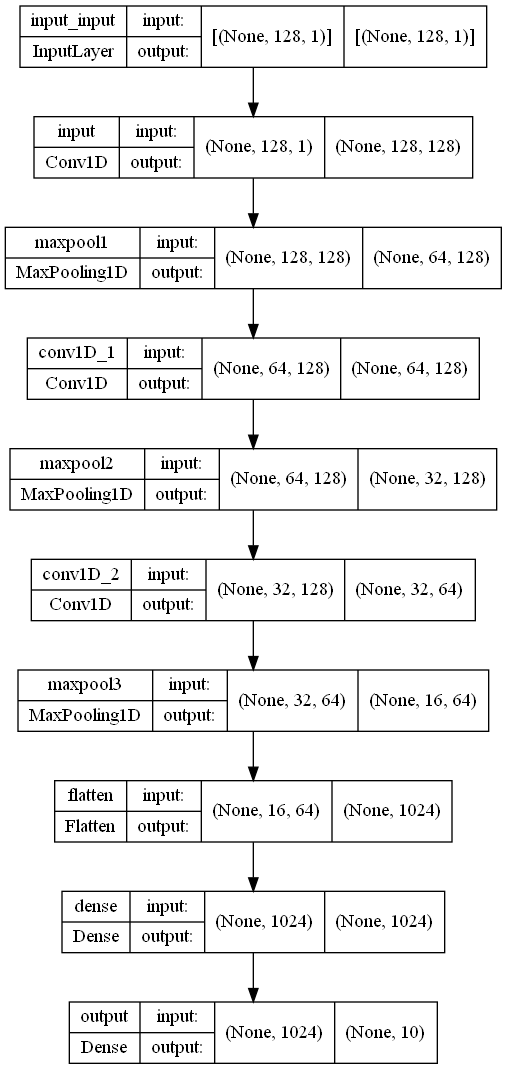

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [9]:
# Compile
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 10s 41ms/step - loss: 3.7690 - accuracy: 0.2669 - val_loss: 2.4564 - val_accuracy: 0.3202
Epoch 2/20
62/62 [==============================] - 1s 15ms/step - loss: 1.7542 - accuracy: 0.4808 - val_loss: 2.3448 - val_accuracy: 0.3945
Epoch 3/20
62/62 [==============================] - 1s 16ms/step - loss: 1.2275 - accuracy: 0.6006 - val_loss: 1.9282 - val_accuracy: 0.4366
Epoch 4/20
62/62 [==============================] - 1s 15ms/step - loss: 0.8609 - accuracy: 0.7169 - val_loss: 1.9235 - val_accuracy: 0.4666
Epoch 5/20
62/62 [==============================] - 1s 16ms/step - loss: 0.6967 - accuracy: 0.7609 - val_loss: 1.9391 - val_accuracy: 0.4729
Epoch 6/20
62/62 [==============================] - 1s 18ms/step - loss: 0.5360 - accuracy: 0.8215 - val_loss: 2.1926 - val_accuracy: 0.4433
Epoch 7/20
62/62 [==============================] - 1s 16ms/step - loss: 0.4040 - accuracy: 0.8701 - val_loss: 2.0301 - val_accuracy: 0.4729
Epoch 8/20
6

In [10]:
model.save("pokemon_model_trained.h5")

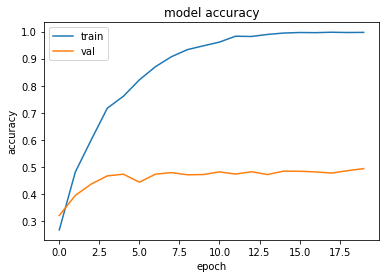

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

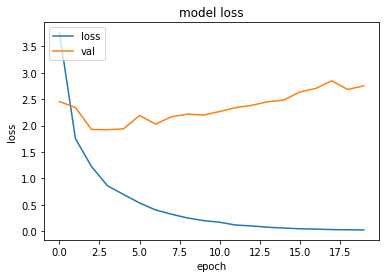

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

### A different Neural network from Keras
https://keras.io/examples/audio/uk_ireland_accent_recognition/

In [13]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Resizing, Normalization, Conv2D, MaxPooling2D, Dropout

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = Normalization(input_shape=X_train[0].shape)
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=X_train)

model2 = Sequential([
    # Downsample the input.
    # Resizing(32, 32),
    # Normalize.
    norm_layer,
    Conv1D(32, 3, activation='relu'),
    Conv1D(64, 3, activation='relu'),
    MaxPool1D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes_indexes)),
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 128, 1)           3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 126, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 124, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 62, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 64)            0         
                                                                 
 flatten (Flatten)           (None, 3968)             

In [14]:
# Compile
model2.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 6s 60ms/step - loss: 7.7973 - accuracy: 0.1269 - val_loss: 9.1217 - val_accuracy: 0.2073
Epoch 2/20
62/62 [==============================] - 3s 41ms/step - loss: 7.8187 - accuracy: 0.1431 - val_loss: 8.1683 - val_accuracy: 0.2073
Epoch 3/20
62/62 [==============================] - 2s 39ms/step - loss: 8.0416 - accuracy: 0.1411 - val_loss: 8.6301 - val_accuracy: 0.2073
Epoch 4/20
62/62 [==============================] - 3s 41ms/step - loss: 7.3100 - accuracy: 0.1411 - val_loss: 5.5799 - val_accuracy: 0.2073
Epoch 5/20
62/62 [==============================] - 3s 46ms/step - loss: 7.6021 - accuracy: 0.1345 - val_loss: 10.9076 - val_accuracy: 0.2073
Epoch 6/20
62/62 [==============================] - 3s 48ms/step - loss: 7.8108 - accuracy: 0.1198 - val_loss: 7.8857 - val_accuracy: 0.2073
Epoch 7/20
62/62 [==============================] - 3s 47ms/step - loss: 7.3016 - accuracy: 0.1335 - val_loss: 8.4793 - val_accuracy: 0.2073
Epoch 8/20
6

### Esta red no funciona bien, se descarta

In [15]:
import keras

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model2 = build_model(X_train[0].shape, len(selected_classes_indexes))

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 1)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 16)      64          ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 128, 16)      0           ['conv1d_3[0][0]']               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 128, 16)      784         ['activation[0][0]']             
                                                                                              

 conv1d_16 (Conv1D)             (None, 8, 128)       16512       ['max_pooling1d_4[0][0]']        
                                                                                                  
 add_4 (Add)                    (None, 8, 128)       0           ['conv1d_19[0][0]',              
                                                                  'conv1d_16[0][0]']              
                                                                                                  
 activation_12 (Activation)     (None, 8, 128)       0           ['add_4[0][0]']                  
                                                                                                  
 max_pooling1d_5 (MaxPooling1D)  (None, 4, 128)      0           ['activation_12[0][0]']          
                                                                                                  
 average_pooling1d (AveragePool  (None, 1, 128)      0           ['max_pooling1d_5[0][0]']        
 ing1D)   

In [16]:
# Compile
model2.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

history2 = model2.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 17s 156ms/step - loss: 4.0481 - accuracy: 0.2321 - val_loss: 2.1936 - val_accuracy: 0.2947
Epoch 2/20
62/62 [==============================] - 7s 105ms/step - loss: 1.8764 - accuracy: 0.3615 - val_loss: 2.0205 - val_accuracy: 0.2974
Epoch 3/20
62/62 [==============================] - 7s 106ms/step - loss: 1.6471 - accuracy: 0.4530 - val_loss: 1.8599 - val_accuracy: 0.3945
Epoch 4/20
62/62 [==============================] - 7s 109ms/step - loss: 1.4431 - accuracy: 0.5152 - val_loss: 1.8021 - val_accuracy: 0.3914
Epoch 5/20
62/62 [==============================] - 5s 81ms/step - loss: 1.2697 - accuracy: 0.5637 - val_loss: 1.8059 - val_accuracy: 0.3932
Epoch 6/20
62/62 [==============================] - 5s 77ms/step - loss: 1.1903 - accuracy: 0.5961 - val_loss: 1.6192 - val_accuracy: 0.4622
Epoch 7/20
62/62 [==============================] - 6s 99ms/step - loss: 1.0776 - accuracy: 0.6239 - val_loss: 1.6073 - val_accuracy: 0.4765
Epoch 8/

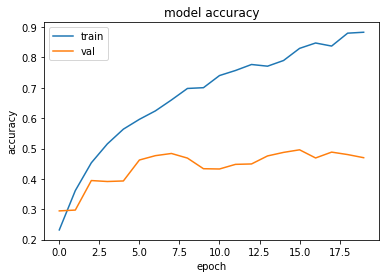

In [17]:
from matplotlib import pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
keras.backend.clear_session()


def build_and_compile_model():
    inputs = keras.layers.Input(X_train[0].shape, name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)
    x = keras.layers.Flatten()(x)

    outputs = keras.layers.Dense(len(selected_classes_indexes), activation="sigmoid", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="sound_recognition")

    model.compile(
        optimizer=Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model


model3 = build_and_compile_model()
model3.summary()

Model: "sound_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 128, 1)]          0         
                                                                 
 dense_1 (Dense)             (None, 128, 256)          512       
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 dense_2 (Dense)             (None, 128, 384)          98688     
                                                                 
 dropout_2 (Dropout)         (None, 128, 384)          0         
                                                                 
 dense_3 (Dense)             (None, 128, 192)          73920     
                                                                 
 dropout_3 (Dropout)         (None, 128, 192)    

In [19]:
history3 = model3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
62/62 [==============================] - 11s 121ms/step - loss: 6.7115 - accuracy: 0.1916 - auc: 0.6365 - val_loss: 2.6739 - val_accuracy: 0.3417 - val_auc: 0.7572
Epoch 2/20
62/62 [==============================] - 5s 85ms/step - loss: 4.0834 - accuracy: 0.3488 - auc: 0.7397 - val_loss: 2.1496 - val_accuracy: 0.4469 - val_auc: 0.8008
Epoch 3/20
62/62 [==============================] - 5s 85ms/step - loss: 3.0486 - accuracy: 0.4383 - auc: 0.8019 - val_loss: 1.9337 - val_accuracy: 0.4783 - val_auc: 0.8308
Epoch 4/20
62/62 [==============================] - 5s 89ms/step - loss: 2.5662 - accuracy: 0.4995 - auc: 0.8325 - val_loss: 1.7184 - val_accuracy: 0.4962 - val_auc: 0.8470
Epoch 5/20
62/62 [==============================] - 5s 89ms/step - loss: 2.2855 - accuracy: 0.5030 - auc: 0.8478 - val_loss: 1.7113 - val_accuracy: 0.5119 - val_auc: 0.8453
Epoch 6/20
62/62 [==============================] - 6s 91ms/step - loss: 2.1652 - accuracy: 0.5344 - auc: 0.8558 - val_loss: 1.5261 -

In [20]:
model3.save("Keras_audio.h5")

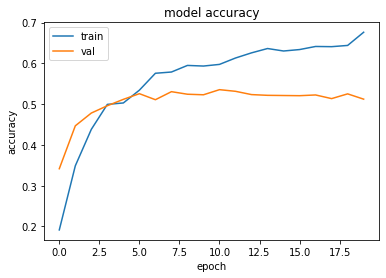

In [21]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

import keras_tuner as kt
from tensorflow import keras

tuner = kt.RandomSearch(
    model3,
    objective='val_loss',
    max_trials=5)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
best_model = tuner.get_best_models()[0]

In [22]:
x = X_val[23].reshape((1,128,1))
print(x.shape)

(1, 128, 1)


In [23]:
new_model = tf.keras.models.load_model("keras_audio.h5")

In [24]:
y = new_model(x)

In [25]:
y

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.30642974, 0.26031238, 0.0606748 , 0.57713926, 0.11113375,
        0.4492974 , 0.7008902 , 0.17415234, 0.8981737 , 0.12313665]],
      dtype=float32)>

In [26]:
np.argmax(y)

8

In [27]:
sol = np.vectorize(lambda x: 1 if x > 0.30 else 0)(y)

In [28]:
[[selected_classes_dict.get(x) for x in tup] for tup in mlb.inverse_transform(sol)]

[['Vehicle horn, car horn, honking',
  'Jackhammer',
  'Traffic noise, roadway noise',
  'Subway, metro, underground',
  'Chatter']]

In [29]:
[[selected_classes_dict.get(x) for x in tup] for tup in mlb.inverse_transform(y_train[9].reshape((1,10)))]

[['Siren']]

In [30]:
y_train[9].shape

(10,)

In [31]:
sol.shape

(1, 10)